# Homework 9
**Alex Smith**<br>
July 13, 2016<br>
MIDS261 - Machine Learning at Scale<br>
Professor Shanahan<br>
Due: July 18, 2016

***
### Useful resources
The following resources were particularly useful.
- [Wikipedia article on PageRank](https://en.wikipedia.org/wiki/PageRank)
- [Networkx Example](https://www.udacity.com/wiki/creating-network-graphs-with-python)

### Libraries
The following libraries must be installed before running the below code. They can all be installed through [Pip](https://github.com/pypa/pip).
- [Scikit Learn](http://scikit-learn.org/stable/)
- [Numpy](http://www.numpy.org/)
- [Regular Expression](https://docs.python.org/2/library/re.html)
- [Pretty Table](https://pypi.python.org/pypi/PrettyTable)
- [Random](https://docs.python.org/2/library/random.html)
- [Datetime](https://docs.python.org/2/library/datetime.html)
- [Matplotlib](http://matplotlib.org/)
- [MRJob](https://pythonhosted.org/mrjob/)
- [Pandas](http://pandas.pydata.org/)
- [Networkx](https://networkx.github.io/)

***
## HW 9.0: Short answer questions
What is PageRank and what is it used for in the context of web search?
What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady state distribution?
OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)

PageRank is a query independent assessment of a webpage's quality. It is an algorithm developed at Google. The motivation behind the algorithm is to rank higher quality pages as more important than lower quality pages. Intuitively, the PageRank algorithm considers a page that has more in-links (other pages linking to it) more important than another page that has less in-links ([Wikipedia](https://en.wikipedia.org/wiki/PageRank)). The idea is that you can use the network graph to determine the importance of a page. For PageRank to work well and compute the steady state distribution using Markov Chains, we need a well-behaved graph. This means that we need **reducible** and **aperiodic** webgraphs. This introduces the idea of teleportation and resolves the problem of danging nodes (webpages with no outlinks). Reducible graphs are ones in which we can reach every other node from a single node. A periodic webgraphs have 1 as the greatest common divisor for all cycle lengths, where a cycle is the number of steps it takes to get from node back to itself.
<img src="https://dl.dropboxusercontent.com/u/37624818/W261_Week9/PageRank.png" alt="pagerank" style="width: 500px;"/>
*[Source](https://en.wikipedia.org/wiki/PageRank)*

***
## HW 9.1: MRJob implementation of basic PageRank

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

A,0.033<br>
B,0.384<br>
C,0.343<br>
D,0.039<br>
E,0.081<br>
F,0.039<br>
G,0.016<br>
H,0.016<br>
I,0.016<br>
J,0.016<br>
K,0.016<br>

### Get the count of the nodes

In [27]:
%%writefile MRnodecount.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRnodecount(MRJob):
    
    # set the count of the number of nodes
    count = 0
    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we use a single reducer in our second 
        # job to bring the sum of all the nodes 
        # together into a single value
        JOBCONF2 = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(mapper=self.mapper,\
                       combiner=self.combiner,\
                       reducer=self.reducer,\
                       reducer_final=self.reducer_final),\
                MRStep(jobconf=JOBCONF2,\
                       mapper=self.mapper2,\
                       reducer=self.reducer2)]       
    
    
    # the mapper takes each line and 
    # yields its own node and all its
    # links
    def mapper(self, _, line):
        
        # split the line into its node
        # and its links
        line = line.strip().split('\t')
        node = int(line[0])
        links = ast.literal_eval(line[1])
        
        # yield this node
        yield node,1
        
        # yield the node's links
        for link in links:
            yield int(link),1
    
    
    # set the combiner to simply emit
    # the nodes with a 1
    def combiner(self,node,counts):
        yield node,1
    
    # the reducer increments the count
    # for each node that passes to it
    def reducer(self,node,counts):
        self.count = self.count + 1
        
    
    # the reducer final yields the 
    # total count of nodes
    def reducer_final(self):
        yield 'count',self.count
        
    
    # the 2nd mapper simply passes what was
    # passed to it
    def mapper2(self,label,counts):
        yield label,counts
        
    
    # the 2nd reducer simply takes the sum
    # of the nodes emitted by each of the 
    # reducers in step 1
    def reducer2(self,label,counts):
        yield label,sum(counts)
    

if __name__ == '__main__':
    MRnodecount.run()

Overwriting MRnodecount.py


In [28]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRnodecount import MRnodecount

# set the MRJob 
mr_job = MRnodecount(args=['PageRank-test_indexed.txt'])

# initialize a variable to hold the 
# total nodes
total_nodes = 0

# create the runner and run it
with mr_job.make_runner() as runner:
    runner.run()
    
    # save the output to a file
    with open('test_nodecount.txt','w') as myfile:
        
        # loop through the lines (there
        # should only be one)
        for line in runner.stream_output():
            
            # grab the key,value
            key,value =  mr_job.parse_output_line(line)
            
            # write the number of nodes to file
            myfile.write(str(value))
            total_nodes = value
            
print "Job completed. Total nodes:",total_nodes

Job completed. Total nodes: 11


In [15]:
# save the file and save the total nodes
total_nodes = 0
with open('test_nodecount.txt','r') as myfile:
    total_nodes = int(myfile.readline())
print "Total nodes:", total_nodes

Total nodes: 11


### Identify and bring out the dangling nodes as additional input files

In [6]:
%%writefile MRdangleNode.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRdangleNode(MRJob):
    
    # define the steps for the MapReduce job
    def steps(self):
        
        return [MRStep(mapper=self.mapper,\
                       combiner=self.combiner,\
                       reducer=self.reducer)]       
    
    
    # the mapper takes each line and 
    # yields its own node and all its
    # links
    def mapper(self, _, line):
        
        # split the line into its node
        # and its links
        line = line.strip().split('\t')
        node = int(line[0])
        links = ast.literal_eval(line[1])
        
        # yield this node
        yield node,links
        
        # yield the node's links
        for link in links:
            yield int(link),{}
    
    
    # set the combiner to combine the 
    # dictionaries of links
    def combiner(self,node,links):
        
        # set a new dictionary to 
        # merge each dictionary into
        new_links = {}
        
        # loop through each link set
        for link_set in links:
            new_links.update(link_set)
            
        yield node,new_links
    
    # the reducer combines the dictionaries
    # of links and then checks for dangling
    # nodes and emits only those
    def reducer(self,node,links):
        
        # set a new dictionary to 
        # merge each dictionary into
        new_links = {}
        
        # loop through each link set
        for link_set in links:
            new_links.update(link_set)
            
        # check if this is a dangling node
        if len(new_links) == 0:
            yield node,new_links
    

if __name__ == '__main__':
    MRdangleNode.run()

Overwriting MRdangleNode.py


In [7]:
# pull out the dangling nodes
!python MRdangleNode.py PageRank-test_indexed.txt --quiet > test_dangling

# show the dangling nodes
!cat test_dangling

1	{}


### Initalize the graph

In [8]:
%%writefile MRgraphinit.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRgraphinit(MRJob):
    
    # set the count of the number of nodes
    # and the weight for each node
    count = 0
    weight = 0
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper=self.mapper,\
                       reducer_init=self.reducer_init,\
                       reducer=self.reducer)]    
    
    
    # configure the options so that we can 
    # pass in the source node of interest
    def configure_options(self):
        super(MRgraphinit, self).configure_options()
        self.add_passthrough_option("--nodes", type='int', default=1)
    
    
    # the mapper takes each line and 
    # outputs the node and
    # also yields all the outbound
    # links from the node. this is so
    # that we can find dangling nodes
    def mapper(self, _, line):
        
        # split the line into its node
        # and its links
        line = line.strip().split('\t')
        node = int(line[0])
        links = ast.literal_eval(line[1])
        
        # set the key,value pair
        key = node
        value = links
        
        # yield the key,value
        yield key,1
        
        # loop through the links emiting
        # each link and an empty dictionary
        for link in links:
            yield int(link),1
        
    
    # the reducer init sets the total 
    # number of nodes for this graph
    def reducer_init(self):
        self.count = self.options.nodes
        self.weight = 1.0 / self.count
        
        
    # the reducer takes each node and 
    # emits its links (if it has any)
    # and adds a uniformly distributed
    # weight
    def reducer(self,node,counts):
                
        # set the key value for each
        # node: node, weight
        key = node
        value = self.weight
        
        yield key,value
            

if __name__ == '__main__':
    MRgraphinit.run()

Overwriting MRgraphinit.py


#### Save the initial file as iteration 0

In [10]:
# set the iteration to 0
iteration = 0
filename = 'test_iter_'+str(iteration)

# create the file
!python MRgraphinit.py PageRank-test_indexed.txt --nodes=$total_nodes --quiet > $filename

# show the output of the file
!cat $filename

1	0.09090909090909091
10	0.09090909090909091
11	0.09090909090909091
2	0.09090909090909091
3	0.09090909090909091
4	0.09090909090909091
5	0.09090909090909091
6	0.09090909090909091
7	0.09090909090909091
8	0.09090909090909091
9	0.09090909090909091


## Develop the transition probability matrix
We develop the transition probability matrix which is the composition of the **hyperlink matrix** and the **teleporting matrix**. The hyperlink matrix is the probability of following a page's links to other pages. The teleporting matrix is the probability of teleporting to any other page in the graph.
![transitionmatrix](https://dl.dropboxusercontent.com/u/37624818/W261_Week9/TransitionMatrix.png)
*Source: Week 10, Synchronous Slides*

In [13]:
%%writefile MRprobMatrix.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRprobMatrix(MRJob):
    
    # set the count of the number of nodes
    # and the dampening factor and the 
    # teleportation weight
    count = 0
    damp = 0
    teleport = 0
    
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper_init = self.reducer_init,\
                       mapper=self.mapper,\
                       combiner=self.combiner,\
                       reducer_init=self.reducer_init,\
                       reducer=self.reducer)]    
    
    
    # configure the options so that we can 
    # pass in the number of nodes and the
    # dampening factor
    def configure_options(self):
        super(MRprobMatrix, self).configure_options()
        self.add_passthrough_option("--nodes", type='int', default=1)
        self.add_passthrough_option("--dampen", type='float', default=0.85)
    
    
    # the mapper takes each line and 
    # outputs its links as keys and 
    # the weight as 1 over the number
    # of links
    def mapper(self, _, line):
        
        # split the line into its node
        # and its links
        line = line.strip().split('\t')
        node = int(line[0])
        links = ast.literal_eval(line[1])
        
        # number of links
        length = len(links)
        
        # loop through the links emiting
        # each link and the weight of that
        # node from this node
        for link in links:
            weight = 1.0/length
            
            # set the key-value pair as the 
            # link and the weight of the
            # source node directed to this
            # node
            key = int(link)
            value = {node:weight}
            yield key,value

        # if we have a dangling node, i.e. no 
        # links to other nodes
        if length == 0:
            
            # loop through every possible node
            # and emit that weight 
            weight = 1.0/self.count
            for i in range(1,self.count+1):
                
                # set the key as the other node
                # and the value as the weight and
                # this dangling node
                key = int(i)
                value = {node:weight}
                yield key,value
        
        # also yield the node itself in
        # the chance that is has no inlinks
        yield node,{}
    
    
    # the combiner merges the dictionaries
    # from mutliple source nodes
    def combiner(self,node,inweights):
        
        # create a dictionary to store
        # the weights
        weights = {}

        # loop through the inweight dictionaries
        for inweight in inweights:
            
            # add to our existing dictionary
            weights.update(inweight)

        # return the node and its inweights
        yield node,weights
    
    
    # the reducer init sets the total 
    # number of nodes for this graph and
    # the dampening factor we care about
    def reducer_init(self):
        self.count = self.options.nodes
        self.damp = self.options.dampen
        
        # calculate the teleportation parameter
        self.teleport = (1.0-self.damp) * (1.0/self.count)
        
        
    # the reducer takes each node and 
    # emits as the inbound weights from
    # every other node
    def reducer(self,node,inweights):

        # create a dictionary to store
        # the weights
        weights = {}

        # loop through the inweight dictionaries
        for inweight in inweights:
            
            # add to our existing dictionary
            weights.update(inweight)

        # create a new dictionary to store the 
        # total weights
        total_weights = {}
        
        # loop through every possible node and assign
        # the inweight
        for i in range(1,self.count+1):
            
            # set the weight for this node
            weight = 0.0
            
            # check to see if this node is one
            # of the linked nodes
            if str(i) in weights:
                weight = weights[str(i)]
                
            # dampen the weight
            weight = self.damp * weight

            # calculate the transition weight
            # as the sum of the hyperlink weight
            # and the teleportation weight
            total_weight = weight + self.teleport

            # add this weight to the matrix
            total_weights[i] = total_weight
            
        # yield the node and all the inweights
        yield node,total_weights
             

if __name__ == '__main__':
    MRprobMatrix.run()

Overwriting MRprobMatrix.py


In [14]:
# set the name of the file and dampening factor
filename = 'test_probMatrix'
dampen = 0.85

# create the file
!python MRprobMatrix.py PageRank-test_indexed.txt test_dangling --nodes=$total_nodes --dampen=$dampen --quiet \
> $filename

# preview the file
!head -3 $filename

1	{"1": 0.09090909090909091, "2": 0.01363636363636364, "3": 0.01363636363636364, "4": 0.4386363636363636, "5": 0.01363636363636364, "6": 0.01363636363636364, "7": 0.01363636363636364, "8": 0.01363636363636364, "9": 0.01363636363636364, "10": 0.01363636363636364, "11": 0.01363636363636364}
10	{"1": 0.09090909090909091, "2": 0.01363636363636364, "3": 0.01363636363636364, "4": 0.01363636363636364, "5": 0.01363636363636364, "6": 0.01363636363636364, "7": 0.01363636363636364, "8": 0.01363636363636364, "9": 0.01363636363636364, "10": 0.01363636363636364, "11": 0.01363636363636364}
11	{"1": 0.09090909090909091, "2": 0.01363636363636364, "3": 0.01363636363636364, "4": 0.01363636363636364, "5": 0.01363636363636364, "6": 0.01363636363636364, "7": 0.01363636363636364, "8": 0.01363636363636364, "9": 0.01363636363636364, "10": 0.01363636363636364, "11": 0.01363636363636364}


### Join the probability matrix and the weights matrix
We can think of PageRank as a join that repeat over and over until we get to convergence. It's a massive join! We perform a simple matrix multiplication where multiple A\*v where A is the probability matrix and v is the vector of current weights. 
![matrixmultiplication](https://dl.dropboxusercontent.com/u/37624818/W261_Week9/matrix-multiply-a.gif)
*[Image source](https://www.mathsisfun.com/algebra/matrix-multiplying.html)*

In [15]:
%%writefile MRrankStep.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
import pandas as pd
  
class MRrankStep(MRJob):
    
    # dictionary of current weights
    original = {}
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,\
                       mapper=self.mapper)]    
    
    
    # configure the options so that we can 
    # pass in the current weights file
    def configure_options(self):
        super(MRrankStep, self).configure_options()
        self.add_file_option('--current_weights')
        
    
    # the mapper init function loads the smaller
    # data frame into memory 
    def mapper_init(self):
        
        # set the filename
        filename = self.options.current_weights
        
        # read the file and save it as a
        # dictionary that we'll reference
        current = pd.read_table(filename,header=None)
        self.original = dict(zip(current.iloc[:,0],current.iloc[:,1]))
        
        
    # the mapper takes each node and completes
    # the dot product to merge it with the 
    def mapper(self, _, line):
        
        # split the line into its node
        # and its weighted links
        line = line.strip().split('\t')
        node = int(line[0])
        links = ast.literal_eval(line[1])
        
        # create a total variable to allow 
        # us to sum for the dot product
        total = 0.0
        
        for link in links:
            
            # set the mass to move
            # and the mass from the 
            # existing weights
            mass1 = links[link]
            mass2 = self.original[int(link)]
            
            # multiply the masses
            # together and add to our
            # running sum
            mass = mass1 * mass2
            total = total + mass
            
        # yield the new mass for that node
        yield node,total
             

if __name__ == '__main__':
    MRrankStep.run()

Overwriting MRrankStep.py


In [16]:
# lets do one iteration of the step
!python MRrankStep.py test_probMatrix --current_weights=test_iter_0 --quiet

1	0.059297520661157024
10	0.020661157024793396
11	0.020661157024793396
2	0.3168732782369147
3	0.0979338842975207
4	0.04641873278236914
5	0.3297520661157025
6	0.04641873278236914
7	0.020661157024793396
8	0.020661157024793396
9	0.020661157024793396


####  Woohoo!
Now that we've shown that this works, let's move on to 10 iterations!

In [17]:
# set the number of iterations that we want
NUM_ITER = 10

# set our transition matrix
TRANSITION = 'test_probMatrix'

# set our current iteration
iteration = 0

# create a while that will allow us to run for
# the number of desired iterations
while iteration < NUM_ITER: 
    
    # set the input filename 
    inputfile = 'test_iter_' + str(iteration)
    
    # increment the iteration
    iteration = iteration + 1
    
    # set the output filename
    outputfile = 'test_iter_' + str(iteration)
    
    # run the program
    !python MRrankStep.py $TRANSITION --current_weights=$inputfile --quiet > $outputfile
    
# show us the final results after ten iterations
final_file = 'test_iter_' + str(iteration)
!cat $final_file

1	0.032930101786204743
10	0.01620712734412402
11	0.01620712734412402
2	0.36323594898891065
3	0.3628837280387183
4	0.03938466342002969
5	0.08114525762548773
6	0.03938466342002969
7	0.01620712734412402
8	0.01620712734412402
9	0.01620712734412402


***
## HW 9.2: Exploring PageRank teleportation and network plots
In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
Using the graph in HW9.1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. Note your plots should look like the following:
![sample](https://dl.dropboxusercontent.com/u/37624818/W261_Week9/PageRank.png)

### Write our function to draw the graph and test it out

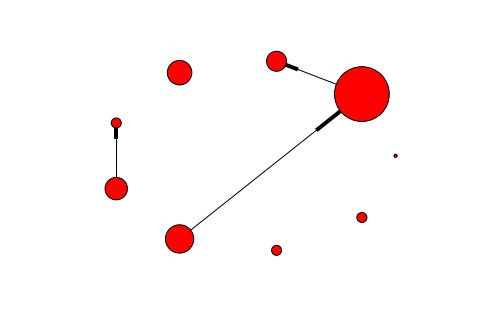

In [8]:
%matplotlib inline

# import our libraries to draw the
# network graph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def draw_graph(nodes, edges, weights):

    # create networkx graph
    G=nx.DiGraph()

    # add nodes
    for node in nodes:
        G.add_node(node)
    
    # add the edges
    for edge in edges:
        G.add_edge(edge[0],edge[1])
    
    
    # draw graph
    pos = nx.shell_layout(G)
    nx.draw(G, pos, node_size=weights)

    # show graph
    plt.show()

# draw an example to make sure that this works
nodes = range(9)
edges = [(1,2),(5,4),(6,1)]
weights = list(np.array([0.1,30,4,6,1,5,8,1,1,4])*100)
draw_graph(nodes,edges,weights)

## <span style="color:violet"> Dampening = 0.85 (using data from 9.1)</span>

### Write functions to get our data in the right format for our graph

In [20]:
# import some libraries to help us get started
import ast

# create a function to identify the edges
def createEdges(filename):
    # create an edges list
    edges = []

    # read in our file for the links
    with open(filename,'r') as myfile:

        # loop through each line
        for line in myfile.readlines():

            # split the line into its node
            # and its links
            line = line.strip().split('\t')
            node = int(line[0])
            links = ast.literal_eval(line[1])

            # loop through the links and add
            # them to the list
            for link in links:
                new_link = node,int(link)
                edges.append(new_link)
                
    # return the edges
    return edges

# get the edges
edges = createEdges('PageRank-test_indexed.txt')

# print that we have loaded in the graph shape
print "Graph shape loaded"
print "Edges:",len(edges)

Graph shape loaded
Edges: 17


In [13]:
# import libraries to help us manipulate the data
import pandas as pd

# write a function to load in the weights and
# the nodes
def getWeights(filename, multiplier = 10000):
    """takes as input a file name and 
    and reads the file name in. returns
    a list of node an a list of corresponding
    node sizes, or weights. by default the
    multiplier is 1000. this the number
    multiplied by the inputted sizes to
    make the circles viewable"""
    
    # create lists to hold the lists of 
    # nodes and weights
    nodes = []
    sizes = []
    
    # read in the weights as a pandas
    # data frame
    data_full = pd.read_table(filename, header=None)
    
    # add column headings to the dataframe
    data_full.columns = ['nodes','weights']
    
    # sort the pandas dataframe
    data_sorted = data_full.sort(columns=['nodes'])
    
    # separate out the columns
    nodes = list(data_sorted.iloc[:,0])
    sizes = list(data_sorted.iloc[:,1])
    
    # increase the sizes to make them
    # visible
    sizes = np.array(sizes)*multiplier
    sizes = list(sizes)
    
    return nodes,sizes

# run the graph on our last iteration
nodes,sizes = getWeights('test_iter_10')

# print out the outcomes
print "Graph nodes and weights loaded"
print "Nodes:", len(nodes)
print "Sizes:",len(sizes)

Graph nodes and weights loaded
Nodes: 11
Sizes: 11


/Users/Alex/miniconda2/envs/main/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### Plot the network graph

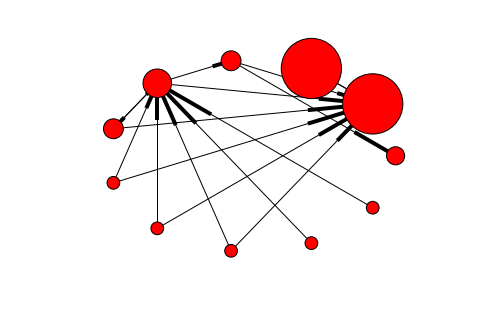

In [14]:
draw_graph(nodes,edges,sizes)

## <span style="color:violet"> Dampening = 1</span>

### Create the transition matrix

In [17]:
# set the name of the file and dampening factor
filename = 'test_probMatrix_1'
dampen = 1.0

# create the file
!python MRprobMatrix.py PageRank-test_indexed.txt test_dangling --nodes=$total_nodes --dampen=$dampen --quiet \
> $filename

# preview the file
!head -3 $filename

1	{"1": 0.09090909090909091, "2": 0.0, "3": 0.0, "4": 0.5, "5": 0.0, "6": 0.0, "7": 0.0, "8": 0.0, "9": 0.0, "10": 0.0, "11": 0.0}
10	{"1": 0.09090909090909091, "2": 0.0, "3": 0.0, "4": 0.0, "5": 0.0, "6": 0.0, "7": 0.0, "8": 0.0, "9": 0.0, "10": 0.0, "11": 0.0}
11	{"1": 0.09090909090909091, "2": 0.0, "3": 0.0, "4": 0.0, "5": 0.0, "6": 0.0, "7": 0.0, "8": 0.0, "9": 0.0, "10": 0.0, "11": 0.0}


### Step through ten iterations of distributing weight

In [18]:
# set the number of iterations that we want
NUM_ITER = 10

# set our transition matrix
TRANSITION = 'test_probMatrix_1'

# set our current iteration
iteration = 0

# create a while that will allow us to run for
# the number of desired iterations
while iteration < NUM_ITER: 
    
    # set the input filename 
    inputfile = 'test_iter_' + str(iteration)
    
    # increment the iteration
    iteration = iteration + 1
    
    # set the output filename
    outputfile = 'test_iter_' + str(iteration)
    
    # run the program
    !python MRrankStep.py $TRANSITION --current_weights=$inputfile --quiet > $outputfile
    
# show us the final results after ten iterations
final_file = 'test_iter_' + str(iteration)
!cat $final_file

1	0.0012251235307801573
10	0.000267729749935862
11	0.000267729749935862
2	0.3820880446086276
3	0.6089920174348892
4	0.0021001253272294076
5	0.002155915021565489
6	0.0021001253272294076
7	0.000267729749935862
8	0.000267729749935862
9	0.000267729749935862


### Graph the network

/Users/Alex/miniconda2/envs/main/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


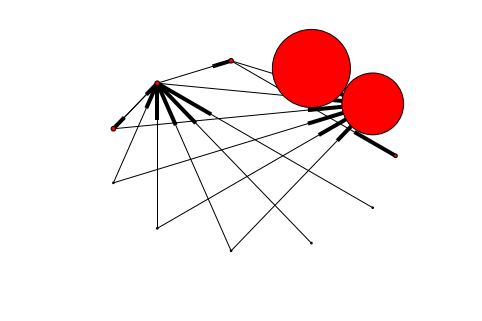

In [21]:
# grab the edges, nodes, and sizes
edges = createEdges('PageRank-test_indexed.txt')
nodes,sizes = getWeights('test_iter_10')

# draw the graph
draw_graph(nodes,edges,sizes)

## <span style="color:violet"> Dampening = 0.75</span>

### Create the transition matrix

In [22]:
# set the name of the file and dampening factor
filename = 'test_probMatrix_75'
dampen = 0.75

# create the file
!python MRprobMatrix.py PageRank-test_indexed.txt test_dangling --nodes=$total_nodes --dampen=$dampen --quiet \
> $filename

# preview the file
!head -3 $filename

1	{"1": 0.09090909090909091, "2": 0.022727272727272728, "3": 0.022727272727272728, "4": 0.3977272727272727, "5": 0.022727272727272728, "6": 0.022727272727272728, "7": 0.022727272727272728, "8": 0.022727272727272728, "9": 0.022727272727272728, "10": 0.022727272727272728, "11": 0.022727272727272728}
10	{"1": 0.09090909090909091, "2": 0.022727272727272728, "3": 0.022727272727272728, "4": 0.022727272727272728, "5": 0.022727272727272728, "6": 0.022727272727272728, "7": 0.022727272727272728, "8": 0.022727272727272728, "9": 0.022727272727272728, "10": 0.022727272727272728, "11": 0.022727272727272728}
11	{"1": 0.09090909090909091, "2": 0.022727272727272728, "3": 0.022727272727272728, "4": 0.022727272727272728, "5": 0.022727272727272728, "6": 0.022727272727272728, "7": 0.022727272727272728, "8": 0.022727272727272728, "9": 0.022727272727272728, "10": 0.022727272727272728, "11": 0.022727272727272728}


### Step through ten iterations of distributing weight

In [23]:
# set the number of iterations that we want
NUM_ITER = 10

# set our transition matrix
TRANSITION = 'test_probMatrix_75'

# set our current iteration
iteration = 0

# create a while that will allow us to run for
# the number of desired iterations
while iteration < NUM_ITER: 
    
    # set the input filename 
    inputfile = 'test_iter_' + str(iteration)
    
    # increment the iteration
    iteration = iteration + 1
    
    # set the output filename
    outputfile = 'test_iter_' + str(iteration)
    
    # run the program
    !python MRrankStep.py $TRANSITION --current_weights=$inputfile --quiet > $outputfile
    
# show us the final results after ten iterations
final_file = 'test_iter_' + str(iteration)
!cat $final_file

1	0.04633213358940749
10	0.025892885505415388
11	0.025892885505415388
2	0.32309008578711174
3	0.2777824624018829
4	0.05451509857829826
5	0.11430069353792441
6	0.05451509857829826
7	0.025892885505415388
8	0.025892885505415388
9	0.025892885505415388


### Graph the network

/Users/Alex/miniconda2/envs/main/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


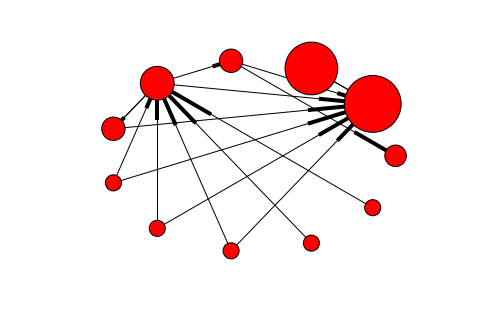

In [24]:
# grab the edges, nodes, and sizes
edges = createEdges('PageRank-test_indexed.txt')
nodes,sizes = getWeights('test_iter_10')

# draw the graph
draw_graph(nodes,edges,sizes)

## <span style="color:violet"> Dampening = 0.5</span>

### Create the transition matrix

In [25]:
# set the name of the file and dampening factor
filename = 'test_probMatrix_50'
dampen = 0.5

# create the file
!python MRprobMatrix.py PageRank-test_indexed.txt test_dangling --nodes=$total_nodes --dampen=$dampen --quiet \
> $filename

# preview the file
!head -3 $filename

1	{"1": 0.09090909090909091, "2": 0.045454545454545456, "3": 0.045454545454545456, "4": 0.29545454545454547, "5": 0.045454545454545456, "6": 0.045454545454545456, "7": 0.045454545454545456, "8": 0.045454545454545456, "9": 0.045454545454545456, "10": 0.045454545454545456, "11": 0.045454545454545456}
10	{"1": 0.09090909090909091, "2": 0.045454545454545456, "3": 0.045454545454545456, "4": 0.045454545454545456, "5": 0.045454545454545456, "6": 0.045454545454545456, "7": 0.045454545454545456, "8": 0.045454545454545456, "9": 0.045454545454545456, "10": 0.045454545454545456, "11": 0.045454545454545456}
11	{"1": 0.09090909090909091, "2": 0.045454545454545456, "3": 0.045454545454545456, "4": 0.045454545454545456, "5": 0.045454545454545456, "6": 0.045454545454545456, "7": 0.045454545454545456, "8": 0.045454545454545456, "9": 0.045454545454545456, "10": 0.045454545454545456, "11": 0.045454545454545456}


### Step through ten iterations of distributing weight

In [26]:
# set the number of iterations that we want
NUM_ITER = 10

# set our transition matrix
TRANSITION = 'test_probMatrix_50'

# set our current iteration
iteration = 0

# create a while that will allow us to run for
# the number of desired iterations
while iteration < NUM_ITER: 
    
    # set the input filename 
    inputfile = 'test_iter_' + str(iteration)
    
    # increment the iteration
    iteration = iteration + 1
    
    # set the output filename
    outputfile = 'test_iter_' + str(iteration)
    
    # run the program
    !python MRrankStep.py $TRANSITION --current_weights=$inputfile --quiet > $outputfile
    
# show us the final results after ten iterations
final_file = 'test_iter_' + str(iteration)
!cat $final_file

1	0.06694802562732
10	0.04849771387367249
11	0.04849771387367249
2	0.22835543402483802
3	0.16278609311415612
4	0.0738014280085016
5	0.1518190218483201
6	0.0738014280085016
7	0.04849771387367249
8	0.04849771387367249
9	0.04849771387367249


### Graph the network

/Users/Alex/miniconda2/envs/main/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


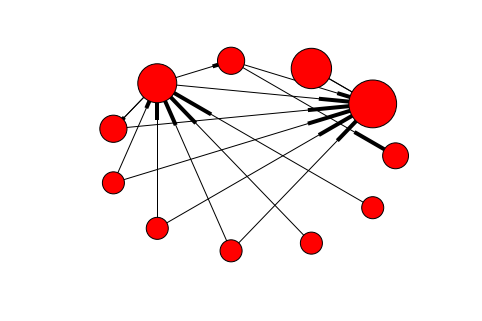

In [27]:
# grab the edges, nodes, and sizes
edges = createEdges('PageRank-test_indexed.txt')
nodes,sizes = getWeights('test_iter_10')

# draw the graph
draw_graph(nodes,edges,sizes)

## <span style="color:violet"> Dampening = 0.25</span>

### Create the transition matrix

In [28]:
# set the name of the file and dampening factor
filename = 'test_probMatrix_25'
dampen = 0.25

# create the file
!python MRprobMatrix.py PageRank-test_indexed.txt test_dangling --nodes=$total_nodes --dampen=$dampen --quiet \
> $filename

# preview the file
!head -3 $filename

1	{"1": 0.09090909090909091, "2": 0.06818181818181818, "3": 0.06818181818181818, "4": 0.19318181818181818, "5": 0.06818181818181818, "6": 0.06818181818181818, "7": 0.06818181818181818, "8": 0.06818181818181818, "9": 0.06818181818181818, "10": 0.06818181818181818, "11": 0.06818181818181818}
10	{"1": 0.09090909090909091, "2": 0.06818181818181818, "3": 0.06818181818181818, "4": 0.06818181818181818, "5": 0.06818181818181818, "6": 0.06818181818181818, "7": 0.06818181818181818, "8": 0.06818181818181818, "9": 0.06818181818181818, "10": 0.06818181818181818, "11": 0.06818181818181818}
11	{"1": 0.09090909090909091, "2": 0.06818181818181818, "3": 0.06818181818181818, "4": 0.06818181818181818, "5": 0.06818181818181818, "6": 0.06818181818181818, "7": 0.06818181818181818, "8": 0.06818181818181818, "9": 0.06818181818181818, "10": 0.06818181818181818, "11": 0.06818181818181818}


### Step through ten iterations of distributing weight

In [29]:
# set the number of iterations that we want
NUM_ITER = 10

# set our transition matrix
TRANSITION = 'test_probMatrix_25'

# set our current iteration
iteration = 0

# create a while that will allow us to run for
# the number of desired iterations
while iteration < NUM_ITER: 
    
    # set the input filename 
    inputfile = 'test_iter_' + str(iteration)
    
    # increment the iteration
    iteration = iteration + 1
    
    # set the output filename
    outputfile = 'test_iter_' + str(iteration)
    
    # run the program
    !python MRrankStep.py $TRANSITION --current_weights=$inputfile --quiet > $outputfile
    
# show us the final results after ten iterations
final_file = 'test_iter_' + str(iteration)
!cat $final_file

1	0.0802296663024089
10	0.070005219725969
11	0.070005219725969
2	0.15573086573584416
3	0.10893799019422111
4	0.08179557278827097
5	0.14148423356113865
6	0.08179557278827097
7	0.070005219725969
8	0.070005219725969
9	0.070005219725969


### Graph the network

/Users/Alex/miniconda2/envs/main/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


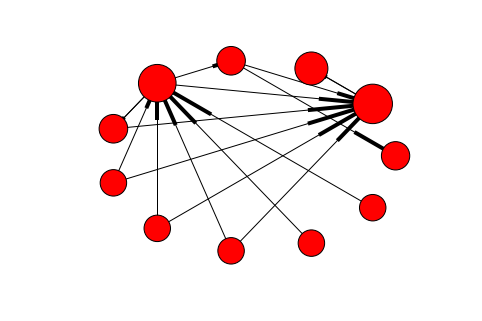

In [30]:
# grab the edges, nodes, and sizes
edges = createEdges('PageRank-test_indexed.txt')
nodes,sizes = getWeights('test_iter_10')

# draw the graph
draw_graph(nodes,edges,sizes)

## <span style="color:violet"> Dampening = 0</span>

### Create the transition matrix

In [31]:
# set the name of the file and dampening factor
filename = 'test_probMatrix_0'
dampen = 0.0

# create the file
!python MRprobMatrix.py PageRank-test_indexed.txt test_dangling --nodes=$total_nodes --dampen=$dampen --quiet \
> $filename

# preview the file
!head -3 $filename

1	{"1": 0.09090909090909091, "2": 0.09090909090909091, "3": 0.09090909090909091, "4": 0.09090909090909091, "5": 0.09090909090909091, "6": 0.09090909090909091, "7": 0.09090909090909091, "8": 0.09090909090909091, "9": 0.09090909090909091, "10": 0.09090909090909091, "11": 0.09090909090909091}
10	{"1": 0.09090909090909091, "2": 0.09090909090909091, "3": 0.09090909090909091, "4": 0.09090909090909091, "5": 0.09090909090909091, "6": 0.09090909090909091, "7": 0.09090909090909091, "8": 0.09090909090909091, "9": 0.09090909090909091, "10": 0.09090909090909091, "11": 0.09090909090909091}
11	{"1": 0.09090909090909091, "2": 0.09090909090909091, "3": 0.09090909090909091, "4": 0.09090909090909091, "5": 0.09090909090909091, "6": 0.09090909090909091, "7": 0.09090909090909091, "8": 0.09090909090909091, "9": 0.09090909090909091, "10": 0.09090909090909091, "11": 0.09090909090909091}


### Step through ten iterations of distributing weight

In [32]:
# set the number of iterations that we want
NUM_ITER = 10

# set our transition matrix
TRANSITION = 'test_probMatrix_0'

# set our current iteration
iteration = 0

# create a while that will allow us to run for
# the number of desired iterations
while iteration < NUM_ITER: 
    
    # set the input filename 
    inputfile = 'test_iter_' + str(iteration)
    
    # increment the iteration
    iteration = iteration + 1
    
    # set the output filename
    outputfile = 'test_iter_' + str(iteration)
    
    # run the program
    !python MRrankStep.py $TRANSITION --current_weights=$inputfile --quiet > $outputfile
    
# show us the final results after ten iterations
final_file = 'test_iter_' + str(iteration)
!cat $final_file

1	0.09090909090909093
10	0.09090909090909093
11	0.09090909090909093
2	0.09090909090909093
3	0.09090909090909093
4	0.09090909090909093
5	0.09090909090909093
6	0.09090909090909093
7	0.09090909090909093
8	0.09090909090909093
9	0.09090909090909093


### Graph the network

/Users/Alex/miniconda2/envs/main/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


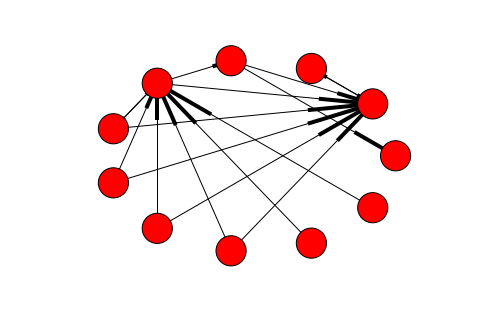

In [33]:
# grab the edges, nodes, and sizes
edges = createEdges('PageRank-test_indexed.txt')
nodes,sizes = getWeights('test_iter_10')

# draw the graph
draw_graph(nodes,edges,sizes)

## <span style="color:violet">Thoughts on dampening factor</span>
The teleportation factor equals 1 minus the dampening factor. So, the higher the dampening factor, the less we teleport. The lower the dampening factor, the more we teleport. When teleport more, we spend our time more equally between nodes. When we teleport less, we let the natural importance of webpages dictate where we spend our time.

***
## HW 9.3: Applying PageRank to the Wikipedia hyperlinks network

(1) Run your PageRank implementation on the Wikipedia dataset for 5 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).<br>
(2) Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). Have the top 100 ranked pages changed? Comment on your findings. <br>
(3) Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  

### Start up a cluster

In [110]:
# create the cluster
!mrjob create-cluster \
--max-hours-idle 1 \
--aws-region=us-west-1 -c ~/.mrjob.conf

Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/no_script.Alex.20160716.234014.992084
Copying local files to s3://mrjob-f8c316b67324528f/tmp/no_script.Alex.20160716.234014.992084/files/...
j-1LKJO48UJGNYK


### Gather the number of nodes

In [111]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRnodecount import MRnodecount

# set the MRJob 
mr_job = MRnodecount(args=['s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt',\
                           '-r','emr',\
                           '--cluster-id=j-1LKJO48UJGNYK', \
                           '--aws-region=us-west-1', \
                           '--output-dir=s3://aks-w261-hw7/out_9-3/node_count', \
                           '--no-output'
                          ])

# initialize a variable to hold the 
# total nodes
total_nodes = 0

# create the runner and run it
with mr_job.make_runner() as runner:
    runner.run()
    
    # save the output to a file
    with open('wiki_nodecount.txt','w') as myfile:
        
        # loop through the lines (there
        # should only be one)
        for line in runner.stream_output():
            
            # grab the key,value
            key,value =  mr_job.parse_output_line(line)
            
            # write the number of nodes to file
            myfile.write(str(value))
            total_nodes = value
            
print "Job completed. Total nodes:",total_nodes

Job completed. Total nodes: 15192277


In [24]:
# save the file and save the total nodes
total_nodes = 0
with open('wiki_nodecount.txt','r') as myfile:
    total_nodes = int(myfile.readline())
print "Total nodes:", total_nodes

Total nodes: 15192277


### Initalize the Wikipedia graph with some initial weights

In [127]:
# set the iteration to 0 and name the output file
iteration = 0
outputfile = 's3://aks-w261-hw9/out_9-3/wiki_iter_'+str(iteration)

# remove the existing output file
!aws s3 rm --recursive $outputfile

# create the file
!python MRgraphinit.py -r emr s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
    --cluster-id=j-1LKJO48UJGNYK \
    --nodes=$total_nodes \
    --aws-region=us-west-1 \
    --output-dir=$outputfile \
    --no-output \
    --quiet
    
# let us know that we're done
!echo "We have initalized the Wikipedia graph with initial weights"

We have initalized the Wikipedia graph with initial weights


### Start up a cluster

In [23]:
# create the cluster
!mrjob create-cluster \
--max-hours-idle 1 \
--aws-region=us-west-1 -c ~/.mrjob.conf

Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/no_script.Alex.20160717.011413.740807
Copying local files to s3://mrjob-f8c316b67324528f/tmp/no_script.Alex.20160717.011413.740807/files/...
j-1XLO1JO4DIUQP


### Find the dangling nodes

In [25]:
# pull out the dangling nodes
!python MRdangleNode.py -r emr s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
    --cluster-id=j-1XLO1JO4DIUQP \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw9/wiki_dangling \
    --no-output \
    --quiet
    
# let us know that we have finished
!echo Dangling nodes found

Dangling nodes found


### Develop the transitory matrix

In [ ]:
# set the name of the file and dampening factor
filename = 's3://aks-w261-hw9/transit_matrix'
dampen = 0.85

# create the file
!python MRprobMatrix.py -r emr \
    s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
    s3://aks-w261-hw9/wiki_dangling \
    --cluster-id=j-1XLO1JO4DIUQP \
    --aws-region=us-west-1 \
    --output-dir=$filename \
    --nodes=$total_nodes \
    --dampen=$dampen \
    --no-output \
    --quiet 

# preview the file
!echo Transitory matrix created

### Step through joining the transition matrix with the weights matrix

In [ ]:
# set the number of iterations that we want
NUM_ITER = 10

# set our transition matrix
TRANSITION = 's3://aks-w261-hw9/transit_matrix'

# set our current iteration
iteration = 0

# create a while that will allow us to run for
# the number of desired iterations
while iteration < NUM_ITER: 
    
    # set the input filename 
    inputfile = 's3://aks-w261-hw9/out_9-3/wiki_iter_' + str(iteration)
    
    # increment the iteration
    iteration = iteration + 1
    
    # set the output filename
    outputfile = 's3://aks-w261-hw9/out_9-3/wiki_iter_' + str(iteration)
    
    # run the program
    !python MRrankStep.py -r emr \
        $TRANSITION \
        --current_weights=$inputfile \
        --cluster-id=j-1XLO1JO4DIUQP \
        --aws-region=us-west-1 \
        --output-dir=$outputfile \
        --no-output \
        --quiet    
    
# print that we're done
!echo Ten iterations are complete

#####  <span style="color:light green">So, after attempting this, I realized that my approach is not scalable because it requires creating this massive 15,000,0000 by 15,000,0000 matrix. I'm going to rework my approach here. Type III fun!</span>

### New approach: make a matrix with weights and links
Rather than performing many iterations of matrix multiplication, I going to think of it as sending the weights around!

### Get the count of the nodes

In [34]:
%%writefile MRnodecount.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRnodecount(MRJob):
    
    # set the count of the number of nodes
    count = 0
    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we use a single reducer in our second 
        # job to bring the sum of all the nodes 
        # together into a single value
        JOBCONF2 = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(mapper=self.mapper,\
                       combiner=self.combiner,\
                       reducer=self.reducer,\
                       reducer_final=self.reducer_final),\
                MRStep(jobconf=JOBCONF2,\
                       mapper=self.mapper2,\
                       reducer=self.reducer2)]       
    
    
    # the mapper takes each line and 
    # yields its own node and all its
    # links
    def mapper(self, _, line):
        
        # split the line into its node
        # and its links
        line = line.strip().split('\t')
        node = int(line[0])
        links = ast.literal_eval(line[1])
        
        # yield this node
        yield node,1
        
        # yield the node's links
        for link in links:
            yield int(link),1
    
    
    # set the combiner to simply emit
    # the nodes with a 1
    def combiner(self,node,counts):
        yield node,1
    
    # the reducer increments the count
    # for each node that passes to it
    def reducer(self,node,counts):
        self.count = self.count + 1
        
    
    # the reducer final yields the 
    # total count of nodes
    def reducer_final(self):
        yield 'count',self.count
        
    
    # the 2nd mapper simply passes what was
    # passed to it
    def mapper2(self,label,counts):
        yield label,counts
        
    
    # the 2nd reducer simply takes the sum
    # of the nodes emitted by each of the 
    # reducers in step 1
    def reducer2(self,label,counts):
        yield label,sum(counts)
    

if __name__ == '__main__':
    MRnodecount.run()

Overwriting MRnodecount.py


In [35]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRnodecount import MRnodecount

# set the MRJob 
mr_job = MRnodecount(args=['PageRank-test_indexed.txt'])

# initialize a variable to hold the 
# total nodes
total_nodes = 0

# create the runner and run it
with mr_job.make_runner() as runner:
    runner.run()
    
    # save the output to a file
    with open('test_nodecount.txt','w') as myfile:
        
        # loop through the lines (there
        # should only be one)
        for line in runner.stream_output():
            
            # grab the key,value
            key,value =  mr_job.parse_output_line(line)
            
            # write the number of nodes to file
            myfile.write(str(value))
            total_nodes = value
            
print "Job completed. Total nodes:",total_nodes

Job completed. Total nodes: 11


In [5]:
# save the file and save the total nodes
total_nodes = 0
with open('test_nodecount.txt','r') as myfile:
    total_nodes = int(myfile.readline())
print "Total nodes:", total_nodes

Total nodes: 11


### Identify and bring out the dangling nodes as additional input files

In [38]:
%%writefile MRdangleNode.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRdangleNode(MRJob):
    
    # define the steps for the MapReduce job
    def steps(self):
        
        return [MRStep(mapper=self.mapper,\
                       combiner=self.combiner,\
                       reducer=self.reducer)]       
    
    
    # the mapper takes each line and 
    # yields its own node and all its
    # links
    def mapper(self, _, line):
        
        # split the line into its node
        # and its links
        line = line.strip().split('\t')
        node = int(line[0])
        links = ast.literal_eval(line[1])
        
        # yield this node
        yield node,links
        
        # yield the node's links
        for link in links:
            yield int(link),{}
    
    
    # set the combiner to combine the 
    # dictionaries of links
    def combiner(self,node,links):
        
        # set a new dictionary to 
        # merge each dictionary into
        new_links = {}
        
        # loop through each link set
        for link_set in links:
            new_links.update(link_set)
            
        yield node,new_links
    
    # the reducer combines the dictionaries
    # of links and then checks for dangling
    # nodes and emits only those
    def reducer(self,node,links):
        
        # set a new dictionary to 
        # merge each dictionary into
        new_links = {}
        
        # loop through each link set
        for link_set in links:
            new_links.update(link_set)
            
        # check if this is a dangling node
        if len(new_links) == 0:
            yield node,new_links
    

if __name__ == '__main__':
    MRdangleNode.run()

Overwriting MRdangleNode.py


In [39]:
# pull out the dangling nodes
!python MRdangleNode.py PageRank-test_indexed.txt --quiet > test_dangling

# show the dangling nodes
!cat test_dangling

1	{}


### Create the initial adjacency list
This list has the node, the links, and the weight, where the weight is 1 divided by the number of nodes.

In [49]:
%%writefile MRgraphAdj.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRgraphAdj(MRJob):
    
    # set the count of the number of nodes
    # and the weight for each node
    count = 0
    weight = 0
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper_init=self.mapper_init,\
                       mapper=self.mapper)]    
    
    
    # configure the options so that we can 
    # pass in the source node of interest
    def configure_options(self):
        super(MRgraphAdj, self).configure_options()
        self.add_passthrough_option("--nodes", type='int', default=1)
    
    
    # the mapper init calculates the weight
    # this is to save on repeating the computation
    # for every record
    def mapper_init(self):
        self.count = self.options.nodes
        self.weight = 1.0 / self.count
    
    # the mapper takes each line and 
    # outputs the node, its links
    # and the weight
    def mapper(self, _, line):
        
        # split the line into its node
        # and its links
        line = line.strip().split('\t')
        node = int(line[0])
        links = ast.literal_eval(line[1])
        
        # convert the links to a simple
        # list since we don't care about 
        # weights
        links = map(int,links.keys())
        
        # set the key,value pair
        key = node
        value = links, self.weight
        
        # yield the key,value
        yield key,value
            

if __name__ == '__main__':
    MRgraphAdj.run()

Overwriting MRgraphAdj.py


In [50]:
# write this adjacency list to a file
!python MRgraphAdj.py test_dangling PageRank-test_indexed.txt --nodes=$total_nodes --quiet > test_iter_0

# show us the list
!cat test_iter_0

1	[[], 0.09090909090909091]
2	[[3], 0.09090909090909091]
3	[[2], 0.09090909090909091]
4	[[1, 2], 0.09090909090909091]
5	[[2, 4, 6], 0.09090909090909091]
6	[[2, 5], 0.09090909090909091]
7	[[2, 5], 0.09090909090909091]
8	[[2, 5], 0.09090909090909091]
9	[[2, 5], 0.09090909090909091]
10	[[5], 0.09090909090909091]
11	[[5], 0.09090909090909091]


### Step through distributing the weight
We write a new function that distributes the mass from a node to other nodes. 

In [9]:
%%writefile MRmoveWgtStep.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRmoveWgtStep(MRJob):
    
    # count of the number of nodes
    count = 0
    
    # dampening factor
    damp = 0.0
    
    # set the teleport weight
    teleport = 0.0
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,\
                       mapper=self.mapper,\
                       combiner=self.combiner,\
                       reducer_init=self.reducer_init,\
                       reducer=self.reducer)]    
    
    
    # configure the options so that we can 
    # pass in the current weights file
    def configure_options(self):
        super(MRmoveWgtStep, self).configure_options()
        self.add_passthrough_option("--nodes", type='int', default=1)
        self.add_passthrough_option("--dampen", type='float', default=1.0)
        
    
    # the mapper init function loads the number
    # of nodes into memory
    def mapper_init(self):
        self.count = self.options.nodes
        
        
    # the mapper takes each node and distributes
    # its weight to its linked nodes
    def mapper(self, _, line):
        
        # split the line into its node
        # and its weighted links
        line = line.strip().split('\t')
        node = int(line[0])
        links_weight = ast.literal_eval(line[1])
        links = links_weight[0]
        weight = float(links_weight[1])
        
        # if we have links to distribute the weight
        # to
        if len(links) > 0:
        
            # set the weight to distribute between
            # links
            dist_weight = weight / len(links)

            # yield each of the links with this
            # new distributed weight
            for link in links:
                key = link
                value = [],dist_weight
                yield key,value
        
        # if we actually have a dangling node
        elif len(links) == 0:
            
            # set the weight to distribute between
            # every possible link in the graph
            dist_weight = weight / self.count

            # loop through every possible and
            # distribute the weight there
            for i in range(1,self.count+1):
                key = i
                value = [],dist_weight
                yield key,value
                
        # yield the actual node with an empty 
        # weight
        key = node
        value = links,0.0
        yield key,value
    
    
    # our combiner sums the weights for 
    # each node and outputs that
    def combiner(self, node, links_weight):
        
        # set the new variables we'd like 
        # to output
        new_links = []
        new_weight = 0.0
        
        # loop through the links_weights
        # and add them to our variables
        for links,weight in links_weight:
            new_links = new_links + links
            new_weight = new_weight + weight
            
        # yield the combined results
        key = node
        value = new_links,new_weight
        yield key,value
    
    
    # our reducer init sets the dampening factor
    # and the amount distributed to each node by
    # the opportunity for teleportation
    def reducer_init(self):
        self.count = self.options.nodes
        self.damp = self.options.dampen
        self.teleport = (1.0-self.damp) * (1.0/self.count)
    
    # our reducer performs the tasks of the
    # combiner but also produces the final weight
    # for each node that incorporates teleportation
    def reducer(self, node, links_weight):

        # set the new variables we'd like 
        # to output
        new_links = []
        new_weight = 0.0
        
        # loop through the links_weights
        # and add them to our variables
        for links,weight in links_weight:
            new_links = new_links + links
            new_weight = new_weight + weight

        # dampen the new weight and add the 
        # teleportation factor
        new_weight = (self.damp * new_weight) + self.teleport
        
        # yield the combined results
        key = node
        value = new_links,new_weight
        yield key,value
    
             
if __name__ == '__main__':
    MRmoveWgtStep.run()

Overwriting MRmoveWgtStep.py


In [2]:
# set the input/output files
input_file = 'test_iter_0'
output_file = 'test_iter_1'

# set the variables
damp = 0.85

# test it out locally
!python MRmoveWgtStep.py $input_file --nodes=$total_nodes --dampen=$damp --quiet > $output_file

# view the output file
!cat $output_file

/bin/sh: $output_file: ambiguous redirect
1	[[], 0.05929752066115703]
10	[[5], 0.020661157024793392]
11	[[5], 0.020661157024793392]
2	[[3], 0.3168732782369146]
3	[[2], 0.09793388429752066]
4	[[1, 2], 0.04641873278236915]
5	[[2, 4, 6], 0.3297520661157025]
6	[[2, 5], 0.04641873278236915]
7	[[2, 5], 0.020661157024793392]
8	[[2, 5], 0.020661157024793392]
9	[[2, 5], 0.020661157024793392]


In [6]:
# let's run it for ten iterations
ITERATIONS = 10
iteration = 0

# set the variables
damp = 0.85

# keep iterating until we get to our desired number
while iteration < ITERATIONS:
    
    # set the input files
    input_file = 'test_iter_' + str(iteration)
    
    # increment the iteration
    iteration = iteration + 1
    
    # set the output files
    output_file = 'test_iter_' + str(iteration)

    # test it out locally
    !python MRmoveWgtStep.py $input_file --nodes=$total_nodes --dampen=$damp --quiet > $output_file

# view the output file
output_file = 'test_iter_' + str(iteration)
!cat $output_file

1	[[], 0.03293010178620472]
10	[[5], 0.016207127344124005]
11	[[5], 0.016207127344124005]
2	[[3], 0.3632359489889102]
3	[[2], 0.36288372803871777]
4	[[1, 2], 0.03938466342002968]
5	[[2, 4, 6], 0.08114525762548767]
6	[[2, 5], 0.03938466342002968]
7	[[2, 5], 0.016207127344124005]
8	[[2, 5], 0.016207127344124005]
9	[[2, 5], 0.016207127344124005]


#####  <span style="color:light green">So, after attempting this, I realized that my approach is not scalable because it requires creating this massive 15,000,0000 by number of dangling nodes list. I'm going to rework my approach here (for the second time...). Type III fun!</span>

### Move the weight for the non-dangling nodes and accumulate the weight for the dangling nodes
We distribute all the weight from the non-dangling nodes to all of their links. For the dangling nodes, we increment a counter that we will use in the second part of this job. 

In [9]:
%%writefile MRmoveWgtStepA.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRmoveWgtStepA(MRJob):
    
    # set the number converter to convert
    # the dangling weight into an integer
    num_converter = 10000000000
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,\
                       mapper=self.mapper,\
                       combiner=self.reducer,\
                       reducer=self.reducer)]    
    
    
    # configure the options so that we can 
    # pass in the current weights file
    def configure_options(self):
        super(MRmoveWgtStepA, self).configure_options()
        self.add_passthrough_option("--num_convert", type='int', default=10000000000)
        
    
    # the mapper init function loads the number
    # converter into memory
    def mapper_init(self):
        self.num_converter = self.options.num_convert
        
    # the mapper takes each node and distributes
    # its weight to its linked nodes
    def mapper(self, _, line):
        
        # split the line into its node
        # and its weighted links
        line = line.strip().split('\t')
        node = int(line[0])
        links_weight = ast.literal_eval(line[1])
        links = links_weight[0]
        weight = float(links_weight[1])
        
        # if we have links to distribute the weight
        # to
        if len(links) > 0:
        
            # set the weight to distribute between
            # links
            dist_weight = weight / len(links)

            # yield each of the links with this
            # new distributed weight
            for link in links:
                key = link
                value = [],dist_weight
                yield key,value
        
        # if we actually have a dangling node
        elif len(links) == 0:
            
            # convert the weight to an integer
            dist_weight = weight * self.num_converter
            
            # increment the dangling mass counter
            self.increment_counter('PageRank_Counters', 'Dangling_Mass', \
                                   int(dist_weight))
                
        # yield the actual node with an empty 
        # weight
        key = node
        value = links,0.0
        yield key,value
    
    
    # our reducer sums the weights for 
    # each node and outputs that
    def reducer(self, node, links_weight):
        
        # set the new variables we'd like 
        # to output
        new_links = []
        new_weight = 0.0
        
        # loop through the links_weights
        # and add them to our variables
        for links,weight in links_weight:
            new_links = new_links + links
            new_weight = new_weight + weight
            
        # yield the combined results
        key = node
        value = new_links,new_weight
        yield key,value
 
             
if __name__ == '__main__':
    MRmoveWgtStepA.run()

Overwriting MRmoveWgtStepA.py


In [17]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRmoveWgtStepA import MRmoveWgtStepA

# test it out on the test file
mr_job = MRmoveWgtStepA(args=['test_iter_0'])
with mr_job.make_runner() as runner:
        runner.run()
        
        # print the dangling mass
        print "Dangling mass:", runner.counters()[0]['PageRank_Counters']['Dangling_Mass']
        
        # create a new file to write to
        with open('test_iter_1A','w') as myfile:
        
            # write the output to a file for testing
            for line in runner.stream_output():
                key,value =  mr_job.parse_output_line(line)
                info = str(key) + str(value) + "\n"
                myfile.write(info)

# let's see the file
print '\n'
!echo Part A of the first step
!cat test_iter_1A

Dangling mass: 909090909


Part A of the first step
1[[], 0.045454545454545456]
10[[5], 0.0]
11[[5], 0.0]
2[[3], 0.3484848484848485]
3[[2], 0.09090909090909091]
4[[1, 2], 0.030303030303030304]
5[[2, 4, 6], 0.36363636363636365]
6[[2, 5], 0.030303030303030304]
7[[2, 5], 0.0]
8[[2, 5], 0.0]
9[[2, 5], 0.0]


In [54]:
%%writefile MRmoveDangleB.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRmoveDangleB(MRJob):
    
    # count of the number of nodes
    count = 0
    
    # dampening factor
    damp = 0.0
    
    # set the teleport weight
    teleport = 0.0
    
    # set the number that helps convert to ints
    num_converter = 10000000000
    
    # set the total dangling mass
    dangle_total = 0
    dangle = 0
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,\
                       mapper=self.mapper)]    
    
    
    # configure the options so that we can 
    # pass in the current weights file
    def configure_options(self):
        super(MRmoveDangleB, self).configure_options()
        self.add_passthrough_option("--nodes", type='int', default=1)
        self.add_passthrough_option("--dampen", type='float', default=1.0)
        self.add_passthrough_option("--num_convert", type='int', default=10000000000)
        self.add_passthrough_option("--dangle", type='int', default=0)
        
    
    # the mapper init function loads the number
    # of nodes into memory, the dampening factor,
    # the teleportation value, and the number convert
    # and the dangling mass
    def mapper_init(self):
        
        # set the count of number of nodes
        self.count = self.options.nodes
        
        # set the user-inputted dampening factor
        self.damp = self.options.dampen
        
        # calculate the added probability for each node
        # due to teleportation
        self.teleport = (1.0-self.damp) * (1.0/self.count)
        
        # set the number converter to convert the
        # dangling mass back to a number less than 1
        self.num_converter = self.options.num_convert
        
        # set the total accumulated mass (the part not 
        # from dangling nodes), and set the part from
        # dangling nodes as 1.0 minus that value. each
        # node then gets that weight equally distributed
        # hence the division by the number of nodes
        self.dangle_total = self.options.dangle / float(self.num_converter)
        self.dangle = self.dangle_total / float(self.count)

        
    # the mapper takes each node and distributes
    # its weight to its linked nodes
    def mapper(self, _, line):
        
        # split the line into its node
        # and its weighted links
        line = line.strip().split('\t')
        node = int(line[0])
        links_weight = ast.literal_eval(line[1])
        links = links_weight[0]
        weight = float(links_weight[1])
        
        # grab the weight from the dangling mass
        # and add it to the existing weight
        weight = weight + self.dangle
        
        # dampen the new weight and add the 
        # teleportation factor
        new_weight = (self.damp * weight) + self.teleport
                       
        # yield the actual node with an empty 
        # weight
        key = node
        value = links,new_weight
        yield key,value
        

if __name__ == '__main__':
    MRmoveDangleB.run()

Overwriting MRmoveDangleB.py


In [55]:
# test both steps
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRmoveWgtStepA import MRmoveWgtStepA
from MRmoveDangleB import MRmoveDangleB

# test it out on the test file
mr_job1 = MRmoveWgtStepA(args=['test_iter_0'])

# run the runner
with mr_job1.make_runner() as runner:
        runner.run()
        
        # capture the dangling mass
        dangling = runner.counters()[0]['PageRank_Counters']['Dangling_Mass']
        
        # print the dangling mass
        print "Dangling mass:", dangling
        
        # create a new file to write to
        with open('test_iter_1A','w') as myfile:
        
            # write the output to a file for testing
            for line in runner.stream_output():
                key,value =  mr_job1.parse_output_line(line)
                info = str(key) + "\t" + str(value) + "\n"
                myfile.write(info)

# let's see the file
print '\n'
!echo Part A of the first step
!cat test_iter_1A
                
# test the second step out on the test file
mr_job2 = MRmoveDangleB(args=['test_iter_1A','--dampen=0.85','--nodes=11','--dangle=909090909'])            

# run the runner
with mr_job2.make_runner() as runner:
        runner.run()
        
        # create a new file to write to
        with open('test_iter_1B','w') as myfile:
        
            # write the output to a file for testing
            for line in runner.stream_output():
                key,value =  mr_job2.parse_output_line(line)
                info = str(key) + "\t" + str(value) + "\n"
                myfile.write(info)

# let's see the file
print '\n'
!echo Part B of the first step
!cat test_iter_1B

Dangling mass: 909090909


Part A of the first step
1	[[], 0.045454545454545456]
10	[[5], 0.0]
11	[[5], 0.0]
2	[[3], 0.3484848484848485]
3	[[2], 0.09090909090909091]
4	[[1, 2], 0.030303030303030304]
5	[[2, 4, 6], 0.36363636363636365]
6	[[2, 5], 0.030303030303030304]
7	[[2, 5], 0.0]
8	[[2, 5], 0.0]
9	[[2, 5], 0.0]


Part B of the first step
1	[[], 0.059297520660454545]
10	[[5], 0.020661157024090913]
11	[[5], 0.020661157024090913]
2	[[3], 0.31687327823621214]
3	[[2], 0.09793388429681818]
4	[[1, 2], 0.046418732781666666]
5	[[2, 4, 6], 0.329752066115]
6	[[2, 5], 0.046418732781666666]
7	[[2, 5], 0.020661157024090913]
8	[[2, 5], 0.020661157024090913]
9	[[2, 5], 0.020661157024090913]


### Gather the number of nodes for Wikipedia

In [57]:
# read in the total nodes
total_nodes = 0
with open('wiki_nodecount.txt','r') as myfile:
    total_nodes = int(myfile.readline())
print "Total nodes:", total_nodes

Total nodes: 15192277


### Start up a cluster

In [82]:
# create the cluster
!mrjob create-cluster \
--max-hours-idle 1 \
--aws-region=us-west-1 -c ~/.mrjob.conf

Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/no_script.Alex.20160718.003446.913179
Copying local files to s3://mrjob-f8c316b67324528f/tmp/no_script.Alex.20160718.003446.913179/files/...
j-2GNH3DUHPMQXR


### Gather the dangling nodes

We have already completed this step when we were working with our old approach. This part of the approach is the same, and so we will not redo it. The dangling nodes are started in s3://aks-w261-hw9/wiki_dangling.

### Create the first adjacency list

In [87]:
# set the output filename
output_file = 's3://aks-w261-hw9/out_9-3/iter_0'

# write this adjacency list to a file
!python MRgraphAdj.py -r emr \
    s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
    s3://aks-w261-hw9/wiki_dangling \
    --cluster-id=j-2GNH3DUHPMQXR \
    --nodes=$total_nodes \
    --aws-region=us-west-1 \
    --output-dir=$output_file \
    --no-output \
    --quiet

# let us know that we're done
!echo "We have created the first adjacency list for Wikipedia."

We have created the first adjacency list for Wikipedia.


### Start up a cluster
We start up another cluster because our job failed on the last cluster

In [7]:
# create the cluster
!mrjob create-cluster \
--max-hours-idle 1 \
--aws-region=us-west-1 -c ~/.mrjob.conf

Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/no_script.Alex.20160719.012249.298897
Copying local files to s3://mrjob-f8c316b67324528f/tmp/no_script.Alex.20160719.012249.298897/files/...
j-IUC08UE0ZOXV


### Test the small dataset on the cloud

In [8]:
# move the file up to s3
!aws s3 cp test_iter_0 s3://aks-w261-hw9/test_iter_0

upload: ./test_iter_0 to s3://aks-w261-hw9/test_iter_0


In [10]:
# run the mrjob for a single iteration
!python MRmoveWgtStep.py -r emr \
        s3://aks-w261-hw9/test_iter_0 \
        --cluster-id=j-IUC08UE0ZOXV \
        --nodes=$total_nodes \
        --dampen=0.85 \
        --aws-region=us-west-1 \
        --output-dir=s3://aks-w261-hw9/test_iter_1 \
        --no-output

Using configs in /Users/Alex/.mrjob.conf
Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/MRmoveWgtStep.Alex.20160719.012939.053789
Copying local files to s3://mrjob-f8c316b67324528f/tmp/MRmoveWgtStep.Alex.20160719.012939.053789/files/...
Adding our job to existing cluster j-IUC08UE0ZOXV
Waiting for step 1 of 1 (s-FSK2UNB0Y0K1) to complete...
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40631/cluster
  RUNNING for 2.4s
  RUNNING for 37.7s
     5.0% complete
  RUNNING for 68.4s
    44.2% complete
  RUNNING for 99.7s
   100.0% complete
  COMPLETED
Attempting to fetch counters from logs...
Looking for step log in /mnt/var/log/hadoop/steps/s-FSK2UNB0Y0K1 on ec2-54-153-14-102.us-west-1.compute.amazonaws.com...
  Parsing step log: ssh://ec2-54-153-14-102.us-west-1.compute.amazonaws.com/mnt/var/log/hadoop/s

### Loop through for 10 iterations
Now that we've confirmed it works on the small dataset, let's try with Wikipedia.

In [ ]:
# read in the total nodes
total_nodes = 0
with open('wiki_nodecount.txt','r') as myfile:
    total_nodes = int(myfile.readline())

# input file
input_file = 's3://aks-w261-hw9/out_9-3/iter_0'
output_file = 's3://aks-w261-hw9/out_9-3/iter_1'

# set the dampening factor
damp = 0.85

# test it out with one iteration
!python MRmoveWgtStep.py -r emr \
        $input_file \
        --cluster-id=j-IUC08UE0ZOXV \
        --nodes=$total_nodes \
        --dampen=$damp \
        --aws-region=us-west-1 \
        --output-dir=$output_file \
        --no-output

Total nodes: 15192277
Using configs in /Users/Alex/.mrjob.conf
Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/MRmoveWgtStep.Alex.20160719.013620.064944
Copying local files to s3://mrjob-f8c316b67324528f/tmp/MRmoveWgtStep.Alex.20160719.013620.064944/files/...
Adding our job to existing cluster j-IUC08UE0ZOXV
Waiting for step 1 of 1 (s-O3GXZF1OW49N) to complete...
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40631/cluster
  RUNNING for 10.6s
   100.0% complete
  RUNNING for 43.3s
     5.0% complete


In [ ]:
# let's run it for ten iterations
ITERATIONS = 10
iteration = 0

# set the variables
damp = 0.85

# keep iterating until we get to our desired number
while iteration < ITERATIONS:
    
    # set the input files
    input_file = 's3://aks-w261-hw9/out_9-3/iter_' + str(iteration)
    
    # increment the iteration
    iteration = iteration + 1
    
    # set the output files
    output_file = 's3://aks-w261-hw9/out_9-3/iter_' + str(iteration)

    # test it out locally
    !python MRmoveWgtStep.py -r emr \
        $input_file \
        --cluster-id=j-2GNH3DUHPMQXR \
        --nodes=$total_nodes \
        --dampen=$damp \
        --aws-region=us-west-1 \
        --output-dir=$output_file \
        --no-output \
        --quiet

# let us know that the deed is done
!echo We have completed the ten iterations

### <span style="color:violet"> OKAY!!! Let's try our third method. We'll restart our clusters. We'll start with a single iteration and then do 10 iterations </span>

In [56]:
# create the cluster
!mrjob create-cluster \
--max-hours-idle 1 \
--aws-region=us-west-1 -c ~/.mrjob.conf

Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/no_script.Alex.20160721.032002.260992
Copying local files to s3://mrjob-f8c316b67324528f/tmp/no_script.Alex.20160721.032002.260992/files/...
j-FK8HOSDOW3ED


In [58]:
# launch our job on the Wikipedia data
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRmoveWgtStepA import MRmoveWgtStepA

# set our iteration number
iteration = 0

# set our input file
input_file = 's3://aks-w261-hw9/out_9-3/iter_' + str(iteration)

# set our intermediate file
iteration = iteration + 1
inter_file = 's3://aks-w261-hw9/out_9-3/iter_' + str(iteration) + 'A'
inter_out = '--output-dir=' + inter_file

# set out final outupt file
output_file = 's3://aks-w261-hw9/out_9-3/iter_' + str(iteration) + 'B'

# run it on the full data
mr_job1 = MRmoveWgtStepA(args=[input_file, \
                              '-r','emr',\
                              '--cluster-id=j-FK8HOSDOW3ED', \
                              '--aws-region=us-west-1', \
                              inter_out, \
                              '--no-output'\
                             ])

# run the runner
with mr_job1.make_runner() as runner:
        runner.run()
        
        # capture the dangling mass
        dangling = runner.counters()[0]['PageRank_Counters']['Dangling_Mass']
        
        # print the dangling mass
        print "Iteration:", iteration
        print "Dangling mass:", dangling

Iteration: 1
Dangling mass: 6192429446


In [60]:
%reload_ext autoreload
%autoreload 2

# import the job we need for the second half of the
# iteration
from MRmoveDangleB import MRmoveDangleB

# set the dampening factor, number of nodes
# and the dangling mass
damp = '--dampen='+str(0.85)
dangle = '--dangle=' + str(dangling)
nodes = '--nodes=' + str(total_nodes)

# set the output file
output_file = '--output-dir=' + output_file

# run the second step out on the wikipedia file
mr_job2 = MRmoveDangleB(args=[inter_file, \
                             '-r','emr', \
                             damp, \
                             dangle, \
                             nodes, \
                             '--cluster-id=j-FK8HOSDOW3ED', \
                             '--aws-region=us-west-1', \
                             output_file, \
                             '--no-output'\
                             ])

# run the runner
with mr_job2.make_runner() as runner:
        runner.run()
        
!echo Second part of first iteration complete!

Second part of first iteration complete!


### <span style="color:violet"> Loop through 10 iterations for real </span>

In [61]:
%reload_ext autoreload
%autoreload 2

# import the job programs
from MRmoveWgtStepA import MRmoveWgtStepA
from MRmoveDangleB import MRmoveDangleB

# start with iteration 1 since 
# we already did that one as a single
# step
iteration = 1

# loop for ten iterations
while iteration <= 10: 
    
    # set the input and output file for part A
    A_input = 's3://aks-w261-hw9/out_9-3/iter_' + str(iteration) + 'B'
    A_output = '--output-dir=s3://aks-w261-hw9/out_9-3/iter_' + str(iteration + 1) + 'A'
    
    # initalize the first job
    mr_job1 = MRmoveWgtStepA(args=[A_input, \
                              '-r','emr',\
                              '--cluster-id=j-FK8HOSDOW3ED', \
                              '--aws-region=us-west-1', \
                              A_output, \
                              '--no-output'\
                             ])
    
    # run the first job
    with mr_job1.make_runner() as runner:
            runner.run()

            # capture the dangling mass
            dangling = runner.counters()[0]['PageRank_Counters']['Dangling_Mass']

            # print the dangling mass
            print "Iteration:", iteration
            print "Dangling mass:", dangling
    
    
    # set the input and output files for part B
    B_input = 's3://aks-w261-hw9/out_9-3/iter_' + str(iteration + 1) + 'A'
    B_output = '--output-dir=s3://aks-w261-hw9/out_9-3/iter_' + str(iteration + 1) + 'B'
    
    # increment the iteration
    iteration = iteration + 1
    
    # set the variables
    # set the dampening factor, number of nodes
    # and the dangling mass
    damp = '--dampen='+str(0.85)
    dangle = '--dangle=' + str(dangling)
    nodes = '--nodes=' + str(total_nodes)
    
    # initalize the second job
    mr_job2 = MRmoveDangleB(args=[B_input, \
                             '-r','emr', \
                             damp, \
                             dangle, \
                             nodes, \
                             '--cluster-id=j-FK8HOSDOW3ED', \
                             '--aws-region=us-west-1', \
                             B_output, \
                             '--no-output'\
                             ])
    
    # run the second job
    with mr_job2.make_runner() as runner:
        runner.run()
        
# print when done
print "We have run",iteration,"iterations and completed PageRank for Wikipedia."

Iteration: 1
Dangling mass: 5002701163
Iteration: 2
Dangling mass: 4667544064
Iteration: 3
Dangling mass: 4559336341
Iteration: 4
Dangling mass: 4521184077
Iteration: 5
Dangling mass: 4506097374
Iteration: 6
Dangling mass: 4499652203
Iteration: 7
Dangling mass: 4496494807
Iteration: 8
Dangling mass: 4494805682
Iteration: 9
Dangling mass: 4493806926
Iteration: 10
Dangling mass: 4493169743
We have run 11 iterations and completed PageRank for Wikipedia.


### Perform a sort to capture the top 100 nodes by weight
We use an MRJob function to find all nodes above a certain threshold. Once this list is small enough, we can easily perform a local sort.

In [ ]:
%%writefile MRtop.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRtop(MRJob):
    
    # count of the number of nodes
    threshold = 0.0

    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we use a single reducer because the 
        # output file should be tiny
        JOBCONF = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(jobconf = JOBCONF, \
                       mapper_init = self.mapper_init,\
                       mapper=self.mapper,\
                       reducer=self.reducer)]    
    
    
    # configure the options so that we can 
    # pass in the current weights file
    def configure_options(self):
        super(MRmoveWgtStep, self).configure_options()
        self.add_passthrough_option("--thresh", type='float', default=0.3)
        
    
    # the mapper init loads the threshold
    # into memory
    def mapper_init(self):
        self.threshold = self.options.thresh
        
        
    # the mapper takes 
    def mapper(self, _, line):
        
        # split the line into its node
        # and its weighted links
        line = line.strip().split('\t')
        node = int(line[0])
        links_weight = ast.literal_eval(line[1])
        links = links_weight[0]
        weight = float(links_weight[1])
        
        # if the node has a weight greater than
        # our threshold, emit it
        if weight > self.threshold:
            key = node
            value = links,weight
            yield key,value
    
    
    # our reducer simply emits the 
    # the nodes it has been given
    def reducer(self, node, links_weight):
        
        # loop through the links_weights
        # and add them to our variables
        for links,weight in links_weight:
            key = node
            value = links,weight
            yield key,value
    
             
if __name__ == '__main__':
    MRtop.run()

### Apply the top function to the 5th iteration

In [ ]:
# set the threshold value we desire
threshold = 0.3

# run the program
!python MRtop.py -r emr \
    s3://aks-w261-hw9/out_9-3/iter_5 \
    --cluster-id=j-2GNH3DUHPMQXR \
    --thresh=$threshold \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw9/top100_5 \
    --no-output \
    --quiet

In [ ]:
# copy the file locally
!aws s3 cp s3://aks-w261-hw9/top100_5/part-00000 top100_5.txt

In [ ]:
%matplotlib inline
# import libraries to help us read the data
import ast
import matplotlib.pyplot as plt

# create a list 
top = []

# open the file
with open('top100_5.txt','r') as myfile:
    
    # read each line
    for line in myfile.readlines():
        
        # split the line into its node
        # and its weighted links
        line = line.strip().split('\t')
        node = int(line[0])
        links_weight = ast.literal_eval(line[1])
        links = links_weight[0]
        weight = float(links_weight[1])
        
        # add the node and the weight to the 
        # tuple
        info = node,weight
        top.append(info)

# sort the list
top_sorted = sorted(top, key=lambda tup: tup[1],reverse=True)

# save the top 100 
top_100 = top_sorted[0:100]

# convert the list into two lists for plotting
x_lab = [x[0] for x in top_100]
y_val = [x[1] for x in top_100]

# get the x_values as simply a list of numbers
# we'll later replace with the labels
x_val = range(len(y_val))

# convert the x labels to strings
x_lab = map(str,x_lab)

# plot the graph
plt.bar(x_val,y_val)
plt.xticks(x_val,x_lab)
plt.title('Most Highly Weighted Nodes After 5 Iterations')
plt.show()

### Apply the top function to the 10th iteration

In [ ]:
# set the threshold value we desire
threshold = 0.3

# run the program
!python MRtop.py -r emr \
    s3://aks-w261-hw9/out_9-3/iter_10 \
    --cluster-id=j-2GNH3DUHPMQXR \
    --thresh=$threshold \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw9/top100_10 \
    --no-output \
    --quiet

In [ ]:
# copy the file locally
!aws s3 cp s3://aks-w261-hw9/top100_10/part-00000 top100_10.txt

In [ ]:
%matplotlib inline
# import libraries to help us read the data
import ast
import matplotlib.pyplot as plt

# create a list 
top = []

# open the file
with open('top100_10.txt','r') as myfile:
    
    # read each line
    for line in myfile.readlines():
        
        # split the line into its node
        # and its weighted links
        line = line.strip().split('\t')
        node = int(line[0])
        links_weight = ast.literal_eval(line[1])
        links = links_weight[0]
        weight = float(links_weight[1])
        
        # add the node and the weight to the 
        # tuple
        info = node,weight
        top.append(info)

# sort the list
top_sorted = sorted(top, key=lambda tup: tup[1],reverse=True)

# save the top 100 
top_100 = top_sorted[0:100]

# convert the list into two lists for plotting
x_lab = [x[0] for x in top_100]
y_val = [x[1] for x in top_100]

# get the x_values as simply a list of numbers
# we'll later replace with the labels
x_val = range(len(y_val))

# convert the x labels to strings
x_lab = map(str,x_lab)

# plot the graph
plt.bar(x_val,y_val)
plt.xticks(x_val,x_lab)
plt.title('Most Highly Weighted Nodes After 10 Iterations')
plt.show()

***
## HW 9.4: Topic-specific PageRank implementation using MRJob

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the following randomly generated network of 100 nodes:

s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:

vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj

for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes.
If beta > 0.5, PageRank is topic-sensitive, 
and if beta < 0.5, the PageRank is anti-topic-sensitive. 
For any value of beta irreducibility should hold,
so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.

<span style="color:blue">The literature's method is difficult to implement because it involves going through the entire graph and capture all the inbound links for a given node and the category for all the inbound links. In essence, we would have to create the whole graph in reverse. After that step, it would be easier to identify which nodes had to be eliminated from which graphs. </span>

### MRJob to count the number of nodes and the number of nodes per topic
We use the following to formulas to modify our existing PageRank algorithm. To accomplish this, we need to calculate the total number of nodes and the number of nodes per topic. We have modified each weight:
- dampening * accumulated_mass + (1-dampening)*beta*(1/|Tj|) IF node in topic
- dampening * accumulated_mass + (1 - dampening)*(1-beta)*(1/(N - |Tj|))
Where |Tj| is the number of nodes in topic and N is the total number of nodes. We try beta at 0.99.

In [7]:
%%writefile MRtopicNodes.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRtopicNodes(MRJob):
    
    # count of the number of nodes
    count = 0
    
    # count of all the topics
    topic_counts = {}

    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we use a single reducer because the 
        # output file should be tiny and we 
        # really just want a single output file
        JOBCONF = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(jobconf = JOBCONF, \
                       mapper=self.mapper, \
                       mapper_final=self.mapper_final, \
                       combiner = self.combiner, \
                       reducer=self.reducer, \
                       reducer_final=self.reducer_final)]    
        
        
    # the mapper takes 
    def mapper(self, _, line):
        
        # split the line into its node
        # and its weighted links
        line = line.strip().split('\t')
        node = int(line[0])
        category = int(line[1])
        
        # increment the total node count
        self.count = self.count + 1
        
        # yield this node with a count of 1
        yield category,1
    
    
    # our mapper final emits the total 
    # nodes
    def mapper_final(self):
        yield 'Total_count', self.count
    
    
    # our combiner simply combines
    # the counts for multiple nodes
    def combiner(self, label, counts):
        yield label,sum(counts)
    
    
    # our reducer sums the counts and emits
    # the nodes and the topic counts
    def reducer(self, label, counts):
        
        # if its the total counts, yield
        # the simple sum of the counts
        if label == 'Total_count':
            self.count = sum(counts)
        
        # update the dictionary with
        # the topic and the count
        else:
            self.topic_counts[int(label)] = sum(counts)
            
            
    # the reducer final emits the final node
    # count, in total and for each category
    def reducer_final(self):
        yield None,self.count
        yield None,self.topic_counts
    
             
if __name__ == '__main__':
    MRtopicNodes.run()

Overwriting MRtopicNodes.py


In [11]:
# run this on the topic file
!python MRtopicNodes.py randNet_topics.txt --quiet > randNet_counts
!cat randNet_counts

null	100
null	{"1": 17, "2": 8, "3": 9, "4": 13, "5": 9, "6": 6, "7": 10, "8": 9, "9": 7, "10": 12}


### Test for dangling nodes
If the total lines are 100, then there are no dangling nodes.

In [13]:
!cat randNet.txt | wc -l

     100


### Read in the total number of nodes

In [14]:
# save the file and save the total nodes
total_nodes = 0
with open('randNet_counts','r') as myfile:
    total_nodes = int(myfile.readline().split('\t')[1])
print "Total nodes:", total_nodes

Total nodes: 100


### Create the adjacency matrix

In [15]:
!python MRgraphAdj.py randNet.txt --nodes=$total_nodes --quiet > randNet_iter0
!head randNet_iter0

1	[[11, 27, 63, 46, 47, 35, 89, 5], 0.01]
2	[[26, 32, 6, 37, 29, 5, 72, 67, 95, 8, 69, 94], 0.01]
3	[[39, 22, 28, 61, 73, 90], 0.01]
4	[[15, 16, 37, 75, 35, 88, 74, 73, 83, 100], 0.01]
5	[[38, 54, 29, 35, 41, 62, 73, 83, 100, 95, 84], 0.01]
6	[[21, 19, 30, 76, 2, 100, 81], 0.01]
7	[[12, 16, 44, 53, 98, 63, 8], 0.01]
8	[[27, 56, 87, 99, 64, 30, 9, 90, 93, 92, 86, 100], 0.01]
9	[[25, 14, 23, 55, 43, 40, 62, 66, 70, 80], 0.01]
10	[[38, 49, 46, 47, 28, 53, 61, 89, 64, 80], 0.01]


### Run non-topic specific PageRank

In [23]:
# test both steps
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRmoveWgtStepA import MRmoveWgtStepA
from MRmoveDangleB import MRmoveDangleB

# set the iterations
iteration = 0

# do 10 iterations
while iteration < 10:
    
    
    # set the files for the first job
    A_input = 'randNet_iter'+str(iteration)+'B'
    A_output = 'randNet_iter'+str(iteration+1)+'A'
    
    # run the first job to distribute the weights
    mr_job1 = MRmoveWgtStepA(args=[A_input])

    # run the runner
    with mr_job1.make_runner() as runner:
            runner.run()

            # capture the dangling mass
            try: 
                dangling = runner.counters()[0]['PageRank_Counters']['Dangling_Mass']
            except:
                dangling = 0

            # print the dangling mass
            print "Dangling mass:", dangling

            # create a new file to write to
            with open(A_output,'w') as myfile:

                # write the output to a file for testing
                for line in runner.stream_output():
                    key,value =  mr_job1.parse_output_line(line)
                    info = str(key) + "\t" + str(value) + "\n"
                    myfile.write(info)

    # set the files for the second job
    B_input = A_output
    B_output = 'randNet_iter'+str(iteration+1)+'B'
    
    # set the dampening factor, number of nodes
    # and dangling mass
    damp = '--dampen=' + str(0.85)
    nodes = '--nodes=' + str(total_nodes)
    dangle = '--dangle=' + str(dangling)
    
    # finalize the weights with teleportation
    mr_job2 = MRmoveDangleB(args=[B_input, damp, nodes, dangle])            

    # run the runner
    with mr_job2.make_runner() as runner:
            runner.run()

            # create a new file to write to
            with open(B_output,'w') as myfile:

                # write the output to a file for testing
                for line in runner.stream_output():
                    key,value =  mr_job2.parse_output_line(line)
                    info = str(key) + "\t" + str(value) + "\n"
                    myfile.write(info)
                    
    # increment the iteration
    iteration = iteration + 1
    
# print that we're done and the header
print "Iterations run",iteration
filename = 'randNet_iter'+str(iteration-1)+'B'
!head $filename

Dangling mass: 0
Dangling mass: 0
Dangling mass: 0
Dangling mass: 0
Dangling mass: 0
Dangling mass: 0
Dangling mass: 0
Dangling mass: 0
Dangling mass: 0
Dangling mass: 0
Iterations run 10
1	[[11, 27, 63, 46, 47, 35, 89, 5], 0.007873147204339525]
10	[[38, 49, 46, 47, 28, 53, 61, 89, 64, 80], 0.011115071003478177]
100	[[10, 39, 48, 33, 51, 53, 52, 67], 0.01537648994160478]
11	[[39, 12, 21, 55, 43, 46, 89, 7, 84], 0.009341760235428822]
12	[[26, 59, 16, 33, 29, 99, 88, 2, 100, 95], 0.009678118206877369]
13	[[54, 52, 77, 65, 92, 85], 0.013178242969528466]
14	[[11, 34, 3, 64, 65, 91, 86], 0.009858289862959672]
15	[[13, 21, 49, 45, 37, 99, 74, 92, 87], 0.01635632545224593]
16	[[24, 10, 58, 57, 65, 9, 85], 0.007682861278234053]
17	[[27, 48, 35, 61, 75, 71, 70, 92, 78], 0.013065790488595712]


### Modify PageRank to make it topic specific
Part A will the stay the same. <br>
Part B will be modified to include a variable dampening vector.

In [43]:
%%writefile MRmoveDangleB_topic.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRmoveDangleB_topic(MRJob):
    
    # count of the number of nodes
    count = 0
    
    # dampening factor
    damp = 0.0
    
    # set the teleport weight
    teleport = 0.0
    
    # set the number that helps convert to ints
    num_converter = 10000000000
    
    # set the total dangling mass
    dangle_total = 0
    dangle = 0
    
    # set the topic of interest
    topic = 0
    
    # set the count for all
    # topics 
    topic_counts = {}
    
    # set the beta option
    beta = 0.99
    
    # set the dictionary of topics
    topics = {}
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,\
                       mapper=self.mapper)]    
    
    
    # configure the options so that we can 
    # pass in the current weights file
    def configure_options(self):
        super(MRmoveDangleB_topic, self).configure_options()
        self.add_passthrough_option("--nodes", type='int', default=1)
        self.add_passthrough_option("--dampen", type='float', default=1.0)
        self.add_passthrough_option("--num_convert", type='int', default=10000000000)
        self.add_passthrough_option("--dangle", type='int', default=0)
        self.add_passthrough_option("--topic", type='int', default=0)
        self.add_passthrough_option("--beta", type='float', default=0.99)
        
    
    # the mapper init function loads the number
    # of nodes into memory, the dampening factor,
    # the teleportation value, and the number convert
    # and the dangling mass
    def mapper_init(self):

        # set the count of number of nodes
        self.count = self.options.nodes
        
        # set the user-inputted dampening factor
        self.damp = self.options.dampen
        
        # calculate the added probability for each node
        # due to teleportation
        self.teleport = (1.0-self.damp) * (1.0/self.count)
        
        # set the number converter to convert the
        # dangling mass back to a number less than 1
        self.num_converter = self.options.num_convert
        
        # set the total accumulated mass (the part not 
        # from dangling nodes), and set the part from
        # dangling nodes as 1.0 minus that value. each
        # node then gets that weight equally distributed
        # hence the division by the number of nodes
        self.dangle_total = self.options.dangle / float(self.num_converter)
        self.dangle = self.dangle_total / float(self.count)
        
        # read in a file that tells us the total number of nodes
        # the count for each topic
        with open('randNet_counts','r') as myfile:
            self.topic_counts = ast.literal_eval(myfile.readlines()[1].split('\t')[1])
            
        # add the beta option
        self.beta = self.options.beta
        
        # set the topic of interest
        self.topic = self.options.topic
        
        # read in the file that gives us the topic
        # assignments
        with open('randNet_topics.txt','r') as myfile:
            
            # read in each line
            for line in myfile.readlines():
                
                # divide the line into 
                # the node and category
                line = line.split('\t')
                node = int(line[0])
                category = int(line[1])
                
                # add the node to the dictionary
                self.topics[node]=category

        
    # the mapper takes each node and distributes
    # its weight to its linked nodes
    def mapper(self, _, line):
        
        # split the line into its node
        # and its weighted links
        line = line.strip().split('\t')
        node = int(line[0])
        links_weight = ast.literal_eval(line[1])
        links = links_weight[0]
        weight = float(links_weight[1])
        
        # grab the weight from the dangling mass
        # and add it to the existing weight
        weight = weight + self.dangle
        
        # check this node's topic
        this_topic = self.topics[node]

        # if this node is the topic of interest
        if this_topic == self.topic: 
            
            # total nodes for the topic
            topic_nodes = self.topic_counts[str(self.topic)]
            
            # multiply the weight by the dampening
            # and then a variable dampening
            new_weight = (self.damp * weight) + \
            (1-self.damp) * self.beta * (1.0 / topic_nodes)
            
            # yield the actual node with its new weight
            key = node
            value = links,new_weight
            yield key,value
            
        # else this node is not in the topic
        else:
            
            # total nodes for the topic
            topic_nodes = self.topic_counts[str(self.topic)]
            
            # multiply the weight by the dampening
            # and then a variable dampening
            new_weight = (self.damp * weight) + \
            (1-self.damp) * (1-self.beta) * (1.0 / (self.count-topic_nodes))
                       
            # yield the actual node with its new weight
            key = node
            value = links,new_weight
            yield key,value
        

if __name__ == '__main__':
    MRmoveDangleB_topic.run()

Overwriting MRmoveDangleB_topic.py


In [46]:
# test both steps
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRmoveWgtStepA import MRmoveWgtStepA
from MRmoveDangleB_topic import MRmoveDangleB_topic

# set the starter for the filename
file_starter = 'randNet_'

# loop through each of the topics
for topic_i in range(1,11):
    
    # set the iterations
    iteration = 0
    
    # set the file starter
    file_starter = file_starter + str(topic_i) + '_iter'

    # do 10 iterations
    while iteration < 10:


        # set the files for the first job
        # with a special file if we're on iteration 0
        A_input = ''
        if iteration == 0:
            A_input = 'randNet_iter0B'
        else: 
            A_input = file_starter+str(iteration)+'B'
        A_output = file_starter+str(iteration+1)+'A'

        # run the first job to distribute the weights
        mr_job1 = MRmoveWgtStepA(args=[A_input])

        # run the runner
        with mr_job1.make_runner() as runner:
                runner.run()

                # capture the dangling mass
                try: 
                    dangling = runner.counters()[0]['PageRank_Counters']['Dangling_Mass']
                except:
                    dangling = 0

                # print the dangling mass
                #print "Dangling mass:", dangling

                # create a new file to write to
                with open(A_output,'w') as myfile:

                    # write the output to a file for testing
                    for line in runner.stream_output():
                        key,value =  mr_job1.parse_output_line(line)
                        info = str(key) + "\t" + str(value) + "\n"
                        myfile.write(info)

        # set the files for the second job
        B_input = A_output
        B_output = file_starter+str(iteration+1)+'B'

        # set the dampening factor, number of nodes
        # and dangling mass
        damp = '--dampen=' + str(0.85)
        nodes = '--nodes=' + str(total_nodes)
        dangle = '--dangle=' + str(dangling)
        topic = '--topic=' + str(topic_i)
        file1 = '--file=randNet_counts'
        file2 = '--file=randNet_topics.txt'

        # finalize the weights with teleportation
        mr_job2 = MRmoveDangleB_topic(args=[B_input, \
                                            damp, \
                                            nodes, \
                                            dangle, \
                                            topic, \
                                            file1, \
                                            file2])            

        # run the runner
        with mr_job2.make_runner() as runner:
                runner.run()

                # create a new file to write to
                with open(B_output,'w') as myfile:

                    # write the output to a file for testing
                    for line in runner.stream_output():
                        key,value =  mr_job2.parse_output_line(line)
                        info = str(key) + "\t" + str(value) + "\n"
                        myfile.write(info)

        # increment the iteration
        iteration = iteration + 1
    
# print that we're done and the header
print "We're done. We've calculated the page ranks for all the topics."

We're done. We've calculated the page ranks for all the topics.


In [47]:
# let's preview the final file for the tenth topic
!head randNet_1_iter2_iter10B

1	[[11, 27, 63, 46, 47, 35, 89, 5], 0.00634943201157466]
10	[[38, 49, 46, 47, 28, 53, 61, 89, 64, 80], 0.008473338275903498]
100	[[10, 39, 48, 33, 51, 53, 52, 67], 0.014725590959595322]
11	[[39, 12, 21, 55, 43, 46, 89, 7, 84], 0.00827393159528176]
12	[[26, 59, 16, 33, 29, 99, 88, 2, 100, 95], 0.02688893538701864]
13	[[54, 52, 77, 65, 92, 85], 0.012952347276721054]
14	[[11, 34, 3, 64, 65, 91, 86], 0.008284568027748953]
15	[[13, 21, 49, 45, 37, 99, 74, 92, 87], 0.013695866974716838]
16	[[24, 10, 58, 57, 65, 9, 85], 0.00665905220065779]
17	[[27, 48, 35, 61, 75, 71, 70, 92, 78], 0.015158672198490165]
